In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import shutil 
from tqdm import tqdm
import os
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
import random
import subprocess
import cv2
from PIL import Image

from torchvision import transforms, models
from torchvision.utils import save_image

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED = 10
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Загрузка данных

In [4]:
data_root = '/kaggle/input/chestxraydataset/chest_xray'
print(os.listdir(data_root)) # проверяем, какие есть директории

['test', 'train']


In [5]:
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'
each_val_img_ind = 20  # Валидация каждое 20-ое изображение будем класть в валидацию

class_names = ['NORMAL', 'PNEUMONIA']

# Создаем директории для train, val, test и virus
for dir_name in [train_dir, val_dir, test_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
    os.makedirs(os.path.join(dir_name, 'VIRUS'), exist_ok=True)  # Создаем папку virus
    
for dir_name in [train_dir, test_dir]:
    for class_name in class_names:
        source_dir = os.path.join(data_root, dir_name, class_name)
        for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
            if 'virus' in file_name:
                if i % each_val_img_ind != 0 or dir_name == 'test':
                    dest_dir = os.path.join(dir_name, 'VIRUS')
                else:
                    dest_dir = os.path.join(val_dir, 'VIRUS')
            else:
                if i % each_val_img_ind != 0 or dir_name == 'test':
                    dest_dir = os.path.join(dir_name, class_name)
                else:
                    dest_dir = os.path.join(val_dir, class_name)
            shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

for dir_name in [train_dir, val_dir, test_dir]:
    os.rename(f'/kaggle/working/{dir_name}/PNEUMONIA', f'/kaggle/working/{dir_name}/BACT')
class_names[1] = 'BACT'
class_names.append('VIRUS')

100%|██████████| 390/390 [00:02<00:00, 148.35it/s]


In [7]:
!dir test

BACT  NORMAL  VIRUS


# Предобработка данных

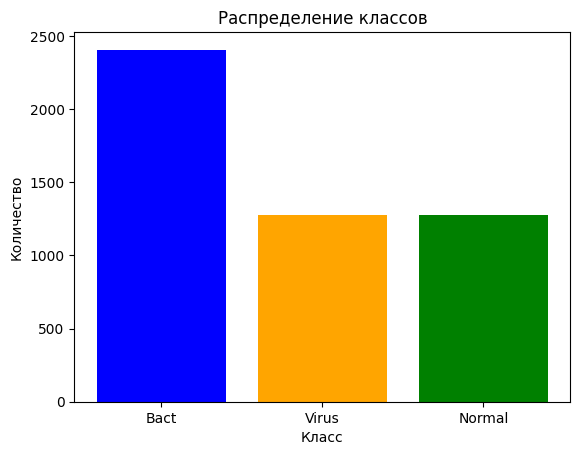

In [8]:
def print_data():
    virus = len(os.listdir('/kaggle/working/train/VIRUS'))
    bact = len(os.listdir('/kaggle/working/train/BACT'))
    normal = len(os.listdir('/kaggle/working/train/NORMAL'))
    labels = ['Bact', 'Virus', 'Normal']
    values = [bact, virus, normal]
    plt.bar(labels, values, color=['blue', 'orange', 'green'])
    plt.title('Распределение классов')
    plt.xlabel('Класс')
    plt.ylabel('Количество')
    plt.show()
print_data()

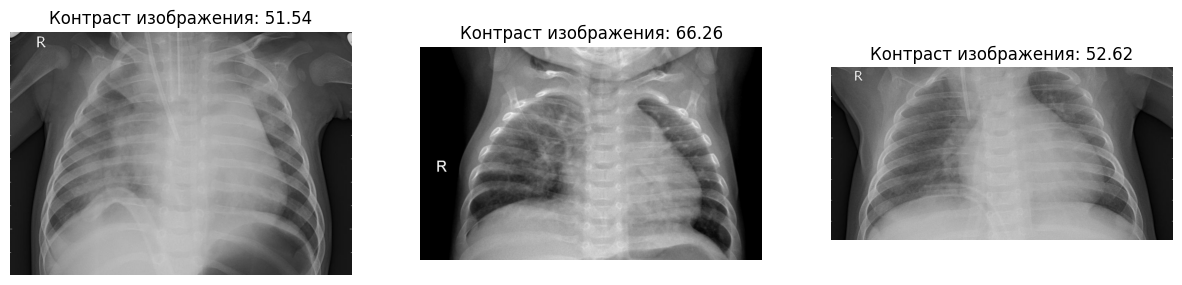

In [9]:
def calculate_contrast(image): 
    image = np.array(image)
    if len(image.shape) == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image

    contrast = np.std(image_gray)
    return contrast

def show_images_for_comparison(folder_path):
    images = []
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    for file_name in image_files[21:24]:
        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path).convert('RGB')
        images.append(image)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for ax, img, file_name in zip(axes, images, image_files[:3]):
        ax.imshow(img)
        ax.set_title(f'Контраст изображения: {round(calculate_contrast(img), 2)}')
        ax.axis('off')
    plt.show()

folder_path = '/kaggle/input/chestxraydataset/chest_xray/test/PNEUMONIA/'
show_images_for_comparison(folder_path)


In [10]:
def get_images_contrast(folder_path):
    contrasts = []
    
    for root, _, files in os.walk(folder_path):
        print(root)
        for file in files:
            image_path = os.path.join(root, file)
            image = cv2.imread(image_path)

            if image is not None:
                contrast = calculate_contrast(image)
                contrasts.append(contrast)
                    
    result_tensor = torch.tensor(contrasts)
    return result_tensor

folder_path = '/kaggle/working/train/'
contrast_tensor = get_images_contrast(folder_path)


/kaggle/working/train/
/kaggle/working/train/NORMAL
/kaggle/working/train/VIRUS
/kaggle/working/train/BACT


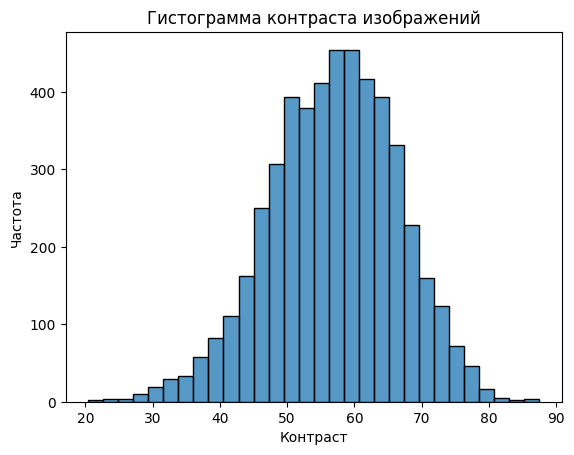

In [11]:
sns.histplot(contrast_tensor.numpy(), bins=30)
plt.xlabel('Контраст')
plt.ylabel('Частота')
plt.title('Гистограмма контраста изображений')
plt.show()


In [13]:
!pip install numpy pillow matplotlib opencv-python ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 3.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 45.0 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


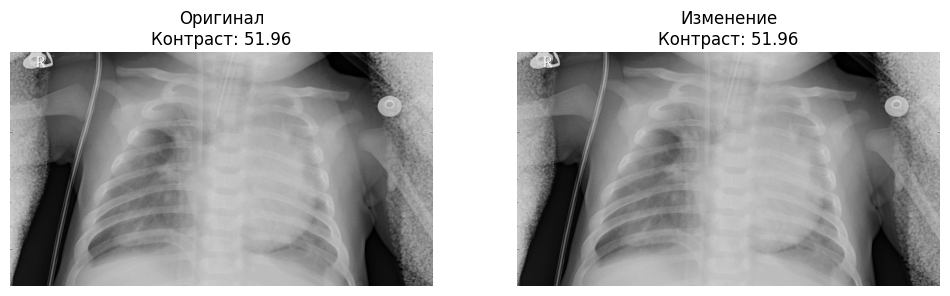

interactive(children=(FloatSlider(value=1.0, description='factor', max=3.0), Output()), _dom_classes=('widget-…

In [14]:
from ipywidgets import interact, FloatSlider, fixed
from torchvision.transforms.functional import adjust_contrast

def adjust_contrast_my(image, factor):
    return adjust_contrast(image, factor)


def display_images_with_contrast(image, factor):
    adjusted_image = adjust_contrast_my(image, factor)
    original_contrast = calculate_contrast(image)
    adjusted_contrast = calculate_contrast(adjusted_image)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(image)
    ax[0].set_title(f'Оригинал\nКонтраст: {original_contrast:.2f}')
    ax[0].axis('off')
    
    ax[1].imshow(adjusted_image)
    ax[1].set_title(f'Изменение\nКонтраст: {adjusted_contrast:.2f}')
    ax[1].axis('off')
    
    plt.show()

image_path = '/kaggle/input/chestxraydataset/chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg'
image = Image.open(image_path).convert('RGB')

interact(display_images_with_contrast, image=fixed(image), factor=FloatSlider(min=0, max=3, step=0.1, value=1.0));


In [15]:
special_transforms = [
    transforms.Compose([
        transforms.Lambda(lambda x: adjust_contrast_my(x, 1.3 if calculate_contrast(x) < 53 else 1)),
        transforms.ToTensor()]),
    
    transforms.Compose([
        transforms.Lambda(lambda x: adjust_contrast_my(x, 1.3 if calculate_contrast(x) < 53 else 1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()]),
]

default_transforms = [
     transforms.Compose([
        transforms.Lambda(lambda x: adjust_contrast_my(x, 1.3 if calculate_contrast(x) < 53 else 1)),
        transforms.ToTensor()]),
]

image_folders_train = ["/kaggle/working/val/BACT", "/kaggle/working/val/NORMAL", "/kaggle/working/val/VIRUS",
                      "/kaggle/working/train/BACT", "/kaggle/working/train/NORMAL", "/kaggle/working/train/VIRUS"]

for image_folder in image_folders_train:
    print(image_folder)
    if image_folder.endswith('BACT'):
        transform = default_transforms
    else:
        transform = special_transforms
        
    for index_image, filename in enumerate(os.listdir(image_folder)):
        
        image_path = os.path.join(image_folder, filename)

        # Применение аугментаций/трансформаций
        for index, trans in enumerate(transform):
            augmented_image = trans(Image.open(image_path))

            name, ext = os.path.splitext(filename)

            augmented_filename = f"{name}_{index}_augmented{ext}"

            output_path = os.path.join(image_folder, augmented_filename)
            save_image(augmented_image, output_path)
        os.remove(image_path)

/kaggle/working/val/BACT
/kaggle/working/val/NORMAL
/kaggle/working/val/VIRUS
/kaggle/working/train/BACT
/kaggle/working/train/NORMAL
/kaggle/working/train/VIRUS


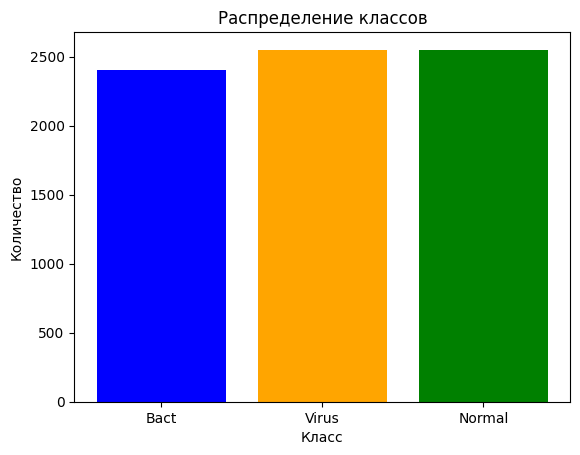

In [16]:
print_data()

In [23]:
augment_transform = [transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
]),
      transforms.Compose([
        transforms.CenterCrop(1200),
        transforms.Resize((224,224)),
        transforms.ToTensor()]),
                  
    transforms.Compose([
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
                 ]

train_dataset = torch.utils.data.ConcatDataset([torchvision.datasets.ImageFolder(train_dir,transform)
                                                    for transform in augment_transform])
#применяем все аугментации

val_dataset = torch.utils.data.ConcatDataset([torchvision.datasets.ImageFolder(val_dir, augment_transform[0])])

batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [24]:
print("train size : {} val size : {}".format(len(train_dataloader), len(val_dataloader)))

train size : 704 val size : 13


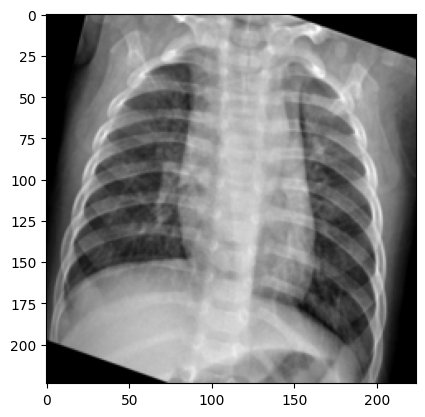

In [25]:
X_batch, y_batch = next(iter(train_dataloader))
plt.imshow(X_batch[0].permute(1, 2, 0).numpy());

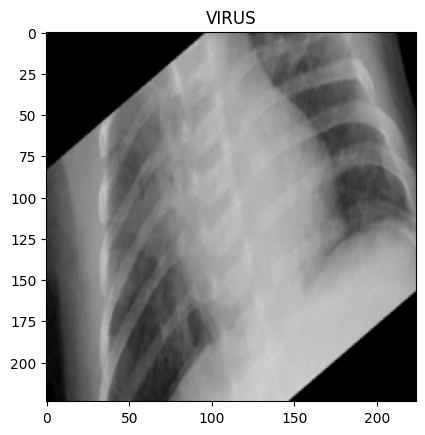

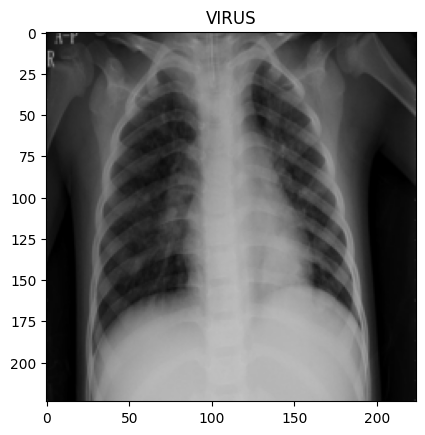

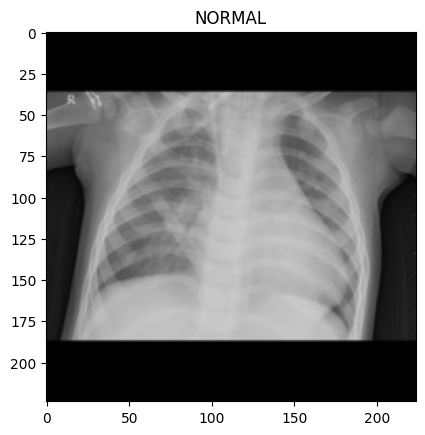

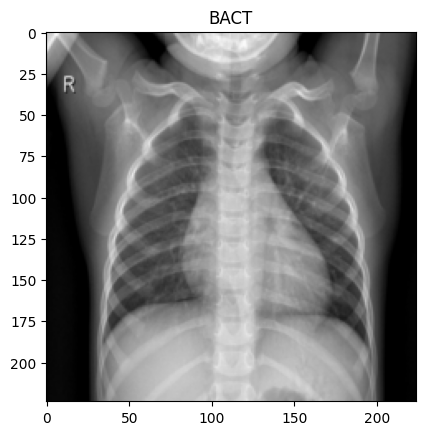

In [26]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in list(zip(X_batch, y_batch))[::8]:
    show_input(x_item, title=class_names[y_item])

# Создание архитектуры сети и её обучение

In [27]:
class CustomNeuralNetResNet(torch.nn.Module):
    def __init__(self,outputs_number):
        super(CustomNeuralNetResNet, self).__init__()
        self.net = models.resnet50(pretrained=True)
        
        for param in self.net.parameters():
            param.requires_grad = False

        TransferModelOutputs = self.net.fc.in_features
        self.net.fc = torch.nn.Sequential(
            torch.nn.Linear(TransferModelOutputs, outputs_number)
        )

    def forward(self, x):
        return self.net(x)

In [28]:
model = CustomNeuralNetResNet(3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = torch.nn.DataParallel(model)
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5, amsgrad=True) # смотреть предыдущие градиенты для лучшей сходимости
 

# Decay LR by a factor of 0.9 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.85)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s] 


In [29]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    best_val_loss = float('inf')
    best_val_acc = 0
    best_model_weights = None
    train_loss = torch.zeros(num_epochs)
    val_loss = torch.zeros(num_epochs)
    train_acc = torch.zeros(num_epochs)
    val_acc = torch.zeros(num_epochs)
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()

            running_loss = 0.
            running_acc = 0.

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
#                     log_probs = torch.nn.functional.log_softmax(preds, dim=1)
#                     loss_value = loss(log_probs, labels)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                train_loss[epoch] = epoch_loss
                train_acc[epoch] = epoch_acc
            else:
                val_loss[epoch] = epoch_loss
                val_acc[epoch] = epoch_acc
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_val_acc =  epoch_acc
                    best_model_weights = model.state_dict()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
    if best_model_weights is not None:
        torch.save(best_model_weights, 'best_model.pth')
        print('Best model saved with loss:', best_val_loss, best_val_acc)

    return train_loss, val_loss, train_acc, val_acc

In [1]:
train_loss, val_loss, train_acc, val_acc = train_model(model, loss, optimizer, scheduler, num_epochs=100)

NameError: name 'train_model' is not defined

# Метрики

In [ ]:
train_loss_list = list()
val_loss_list = list()
train_acc_list = list()
val_acc_list = list()

In [ ]:
train_loss_list.append(train_loss.numpy())
val_loss_list.append(val_loss.numpy())
train_acc_list.append(train_acc.numpy())
val_acc_list.append(val_acc.numpy())

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(25, 10))
# title = ['NLLLoss + SGD', 'NLLLoss + Adam', 'CrossEntropyLoss + SGD', 'CrossEntropyLoss + Adam']
title = ['resnet50', 'resnet50 pret', 'resnet101 pret', 'resnet101 pret']


for i in range(4):
    # Графики потерь
    axs[0][i].plot(train_loss_list[i], label='train loss')
    axs[0][i].plot(val_loss_list[i], label='val loss')
    axs[0][i].set_title(f'{title[i]} Loss')
    axs[0][i].legend(loc='best')
    
    # Графики точности
    axs[1][i].plot(train_acc_list[i], label='train acc')
    axs[1][i].plot(val_acc_list[i], label='val acc')
    axs[1][i].set_title(f'{title[i]} Accuracy')
    axs[1][i].legend(loc='best')

fig.suptitle('Comparison', fontsize=16)
plt.tight_layout()
plt.show()

In [95]:
train_loss = train_loss.numpy()
val_loss = val_loss.numpy()
train_acc = train_acc.numpy()
val_acc = val_acc.numpy()

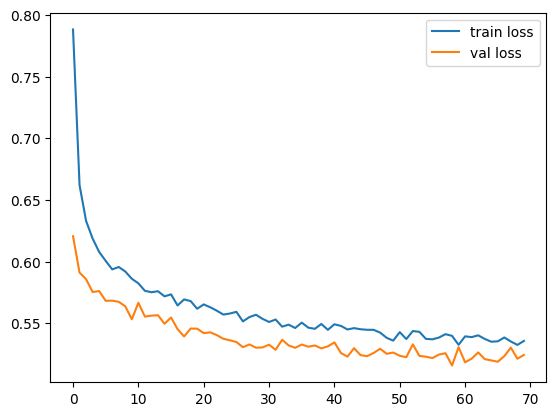

In [96]:
plt.plot(train_loss, label = 'train loss')
plt.plot(val_loss, label = 'val loss')
plt.legend(loc='best')
plt.show()

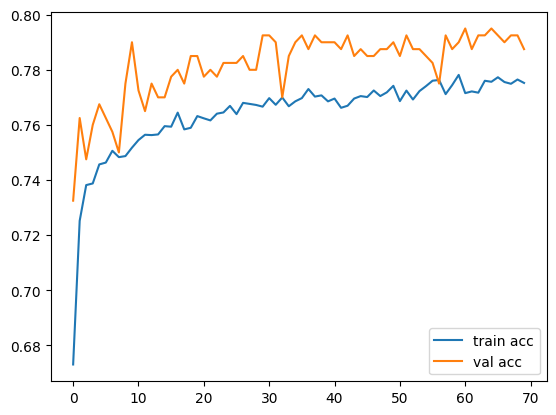

In [97]:
plt.plot(train_acc, label = 'train acc')
plt.plot(val_acc, label = 'val acc')
plt.legend(loc='best')
plt.show()

100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Accuracy: 0.8205
Precision: 0.8175
Recall: 0.8255


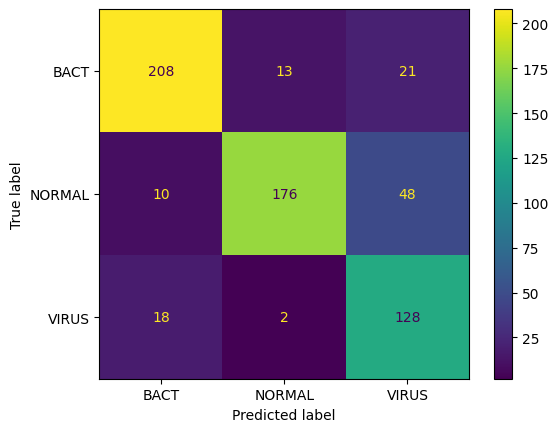

In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

test_transform = transforms.Compose([
    transforms.Lambda(lambda x: adjust_contrast_my(x, 1.3 if calculate_contrast(x) < 53 else 1)),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_dir = 'test'
test_dataset = torchvision.datasets.ImageFolder(test_dir, test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
class_names = test_dataloader.dataset.classes

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            preds = model(inputs)
            preds_class = preds.argmax(dim=1)
            all_preds.extend(preds_class.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')

    return all_labels, all_preds, accuracy, precision, recall

def plot_confusion_matrix(labels, preds, class_names):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()

all_labels, all_preds, accuracy, precision, recall = evaluate_model(model, test_dataloader)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
plot_confusion_matrix(all_labels, all_preds, class_names)


In [104]:
model = CustomNeuralNetResNet(3).to(device)
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model.eval()

CustomNeuralNetResNet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


In [106]:
data_root = '/kaggle/input/test-pnemonia'
test_dir = 'vis_test'
shutil.copytree(os.path.join(data_root), os.path.join(test_dir, 'unknown'))

'vis_test/unknown'

In [107]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_data = 'vis_test/'
test_dataset = ImageFolderWithPaths(test_data, test_transform)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

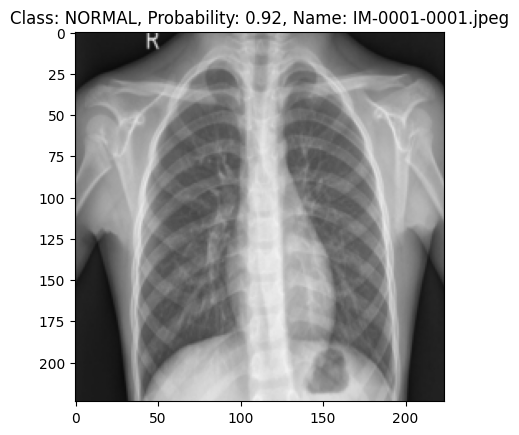

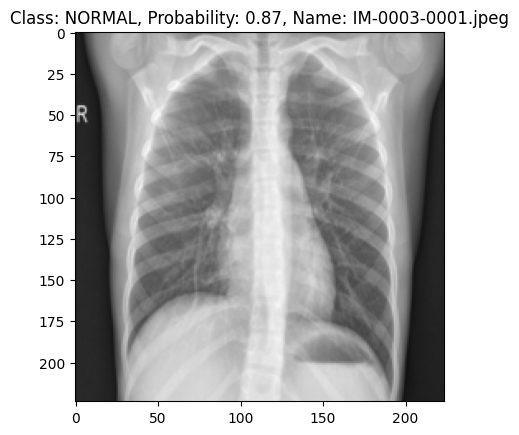

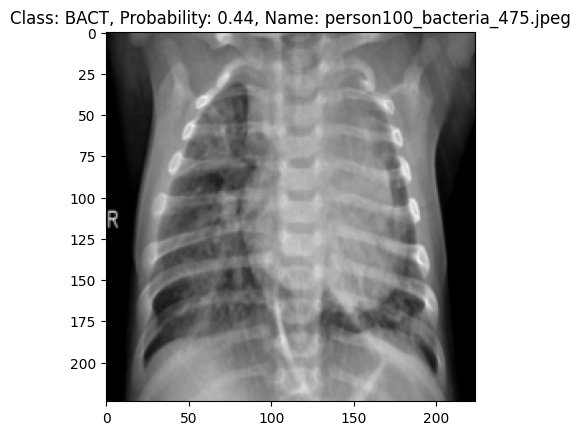

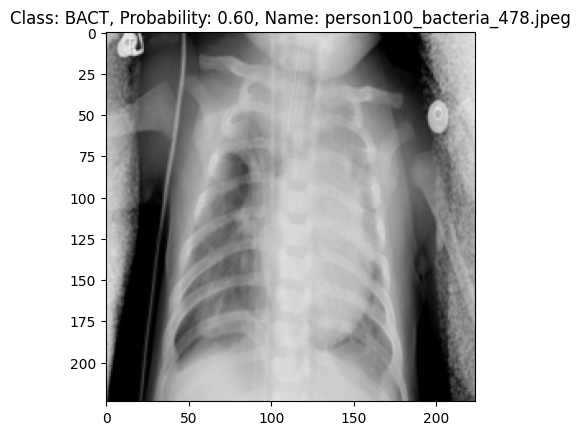

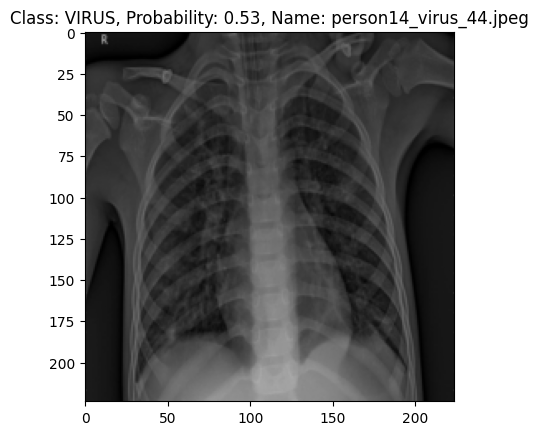

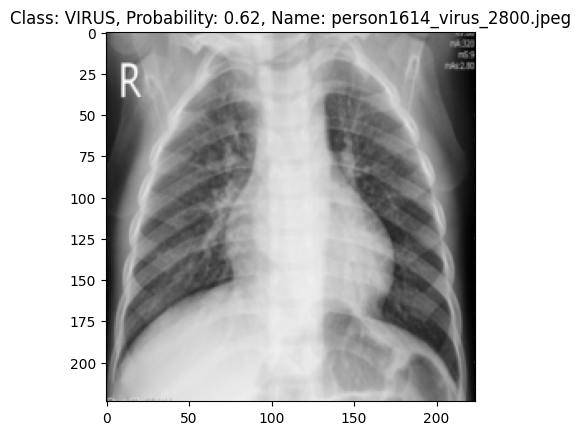

In [108]:
n_images = 1
iter_obj = iter(test_dataloader)

for _ in range(n_images):
    inputs, labels, paths = next(iter_obj)
    inputs = inputs.to(device)
    
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    
    for i, (img, pred) in enumerate(zip(inputs, preds)):
        pred = torch.nn.functional.softmax(pred, dim=0).cpu().numpy()
        img = img.cpu()
        
        predicted_class = np.argmax(pred)
        probability = pred[predicted_class]
        
        name = paths[i].split('/')[-1]
        
        title = f'Class: {class_names[predicted_class]}, Probability: {probability:.2f}, Name: {name}'
        show_input(img, title=title)


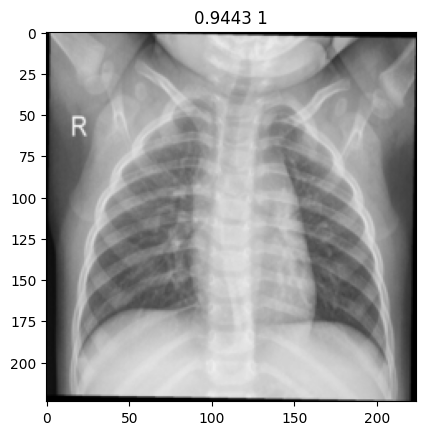

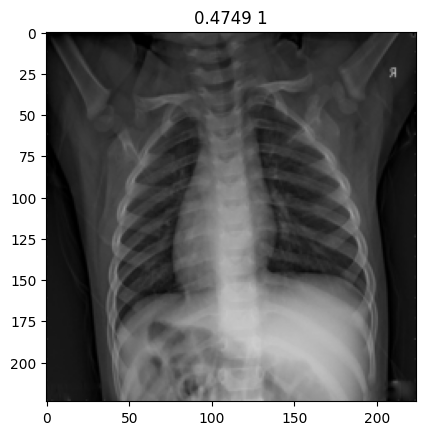

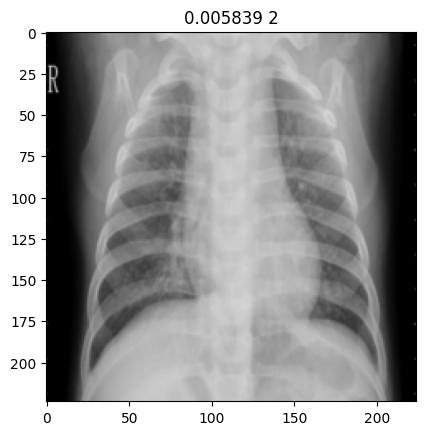

In [109]:
n_images = 1
iter_obj = iter(val_dataloader)

dirty_probs = []
clean_probs = []

for _ in range(n_images):
    X_batch, y_batch = next(iter(iter_obj))
    X_batch = X_batch.to(device)
    with torch.set_grad_enabled(False):
        preds = model(X_batch)
    for img, pred_label in list(zip(X_batch, zip(preds, y_batch)))[::9]:
            pred, label = pred_label
            pred = torch.nn.functional.softmax(pred).data.cpu().numpy()
            pred = pred[1]
            img = img.cpu()
            show_input(img, title="{:.4} {}".format(pred, label))

# Завершение сессии 

In [7]:
import shutil

files = os.listdir('/kaggle/working/')

for file in files:
    if os.path.isfile(file):
        os.remove(file)  # Удалить файл
    else:
        shutil.rmtree(file)  # Удалить директорию


In [88]:
import gc

def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

clear_gpu_memory()
